## Optimal Control of Noisy Lotka-Volterra System

The same techniques used for studying the statistics of stochastic processes can be used to study different variations of stochastic optimal control problems.

In this example, we consider a problem from population control. The control system is modeling the interaction between a predator and prey species modeled by the following diffusion dynamcis
$$ 
        \begin{bmatrix} dx_{1} \\ d x_{2} \end{bmatrix} = \begin{bmatrix} γ_1 x_1 - γ_2 x_1 x_2 \\ \gamma_4 x_1 x_2 - \gamma_3 x_2 - x_2 u \end{bmatrix} \, dt + \begin{bmatrix} \gamma_5 x_1  \\ 0 \end{bmatrix} dW_t
$$    
The control action u models the hunting effort of the predator species, while x₁ and x₂ refer to the population sizes of both species. The goal is to control the population sizes to a desired level of x₁ = 0.75 and x₂ = 0.5. To that end, we solve the following optimal control problem:
$$
\begin{align}
        \min_{u(\cdot)} \quad & \mathbb{E}\left[ \int_0^T (x_1(t) - 0.75)^2 + \frac{(x_2(t) - 0.5)^2}{10} + \frac{(u(t) - 0.5)^2}{10} dt\right] \\
        \text{s.t.} \quad    & u(t) ∈ [0,1], \\
                & x(t) ∈ \mathbb{R}^2_+, \\
                & x(0) \sim \mu_0
\end{align}
$$
To solve this problem we define the associated `ControlProcess` in two steps. First, we define the diffusion process via its diffusion matrix, drift coeff. and state space:

In [1]:
using MarkovBounds, MosekTools, Plots, DifferentialEquations
@polyvar(x[1:2]) # state variables
@polyvar(u) # control variables
@polyvar(t) # time variable
X = @set(x[1] >= 0 && x[2] >= 0) # state space

γ = [1, 2, 1, 2, 0.25*0.1] # model parameters

f = [γ[1] * x[1] - γ[2] * x[1] * x[2] ;
     γ[4] * x[1] * x[2] - γ[3] * x[2] - x[2]*u] # drift coefficient

g = [γ[5]*x[1]; 0] # diffusion coefficient
σ = polynomial.(g*g') # diffusion matrix
lv = DiffusionProcess(x, f, σ, X, iv = t, controls = [u]) 

Diffusion Process
-----------------------
  States: [x₁, x₂]
  Drift: [x₁ - 2.0x₁x₂, -x₂ - x₂u + 2.0x₁x₂]
  Diffusion: [0.0006250000000000001x₁² 0.0; 0.0 0.0]
  State space: { (x[1], x[2]) | x[1] ≥ 0, x[2] ≥ 0 }


In a second step, we define the control process with its objective function and set of admissible control actions.

In [2]:
U = @set(u >= 0 && u <= 1) # set of admissible controls|
stagecost = (x[1]-0.75)^2 + (x[2] - 0.5)^2/10 + (u - 0.5)^2/10
obj = Lagrange(stagecost) # Lagrange type objective
T = 10.0 # control horizon
lv_control = ControlProcess(lv, T, U, obj)

Control Process
-----------------------
Diffusion Process
-----------------------
  States: [x₁, x₂]
  Drift: [x₁ - 2.0x₁x₂, -x₂ - x₂u + 2.0x₁x₂]
  Diffusion: [0.0006250000000000001x₁² 0.0; 0.0 0.0]
  State space: { (x[1], x[2]) | x[1] ≥ 0, x[2] ≥ 0 }
-----------------------
Admissible Controls: { (u) | u ≥ 0, 1 - u ≥ 0 }
Control Horizon: [0, 10.0]
Objective Function: 𝔼[∫ 0.6125 - 0.1*u - 0.1*x[2] - 1.5*x[1] + 0.1*u^2 + 0.1*x[2]^2 + x[1]^2 dt + 0]



Now almost everything is set up to determine a lower bound on the objective value associated with the control problem CP. We only need to specify the distribution of the initial state of the process. This specification is done through the moments of the distribution. In this example, we consider the the initial condition to be known deterministically such that the moments are easily computed. The moments are supplied in form of a dictionary mapping the monomial of the state to the corresponding moment.

The number of moments that needs to be specified depends on the relaxation order used: If order d is used, all moments up to order d + max(deg(f) - 1, deg(σ) - 2, 0) require specification.

In [3]:
order = 6
x0 = [1.0, 0.25]
μ0 = Dict(x[1]^i*x[2]^j => x0[1]^i*x0[2]^j for i in 0:order+1, j in 0:order+1) # moments of initial distribution
trange = range(0, T, length = 11) # discretization of time horizon
solver = optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0)
b = optimal_control(lv_control, μ0, order, trange, solver)

0.20860164397494824 valid (potentially suboptimal)


From the model output we can further identify a polynomial approximation to the value function. If the time horizon is discretized in more than one piece, this approximation will be a piecewise polynomial. By calling the value_function function as shown below we can extract this piecewise polynomial in the form of two functions. The first output maps any point (x,t) -> to the corresponding polynomial, while the second output is a function that directly evaluates this polynomial at (x,t):

In [4]:
V_poly, V_val = value_function(lv_control, trange, b);

This information can be used to construct controllers as shown in the following

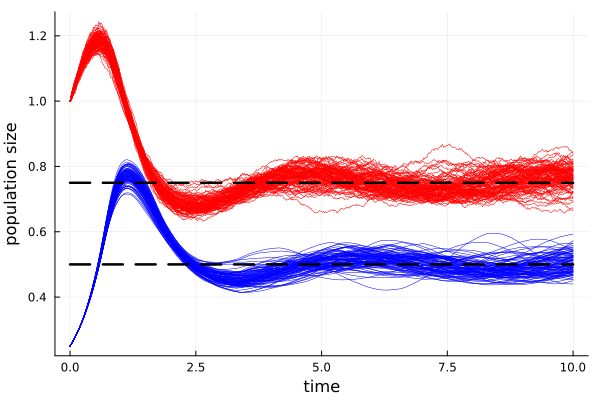

In [5]:
urange = 0:0.05:1
function controller(x,s)
    obj = stagecost + extended_inf_generator(lv, V_poly(s,x))
    return urange[argmin([obj(x...,u,s) for u in urange])]
end

drift(x,p,t) = [f[1](x...), f[2](x..., controller(x, t))]
diffusion(x,p,t) = [g[1](x[1]), 0]
prob = EnsembleProblem(SDEProblem(drift, diffusion, x0, (0.0, T)))
sol = DifferentialEquations.solve(prob, EM(), dt = 0.01, trajectories = 100)

p = plot(legend=false, xlabel="time", ylabel="population size")
for s in sol
    plot!(p, s.t, [u[1] for u in s.u], color=:red, linewidth=0.5)
    plot!(p, s.t, [u[2] for u in s.u], color=:blue, linewidth=0.5)
end
plot!(p, [0,T], [0.75,0.75], style=:dash, color=:black, linewidth=2.5)
plot!(p, [0,T], [0.5,0.5], style=:dash, color=:black, linewidth=2.5)
display(p)